Take the gridded data and create regional averages for each of the HUC2 regions.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import xarray as xr
import regionmask

import geopandas as gpd

## Option to set working directory
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data')) # obviously this would change to my directories!

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
# Load directories
idir = '/glade/u/home/maritye/PROGS/PSIF-WaterAvail/Data/'
figdir = '/glade/work/maritye/Data/PSIF-WaterAv/Figures/'

In [3]:
# open shapefile to use as an aoi

flnm_shp = '/glade/work/mingge/SHAPEFILES/usgs_hucs/HUC02_conus.shp'
huc2_gdf = gpd.read_file(flnm_shp)


Open the file that contains 95th threshold (Q95), number of days above Q95, timeseries of days that are at or above Q95 (P95), total on those days per year (P95Sum) and proportional contribution to the annual total (P95tot)

In [5]:
with xr.open_dataset(idir + 'CESM001-010_PRECT_1981-2010.nc') as dp:
    print('dp')
with xr.open_dataset(idir + 'CESM001-010_PRECT_2040-2070.nc') as df:
    print('df')

dp
df


In [135]:
with xr.open_dataset(idir + 'PRECT_CESM2_001-010_1981-2010_95th.nc') as file_nc:
    dp95_xr = file_nc.drop('quantile').squeeze()

In [6]:
"""
# check a smaller selection by extracting just the huc regions in the west
rg_uco_lco_gb_pnw_ca = huc2_gdf[huc2_gdf.str_id.isin(
    ['LCO', 'CA', 'UC', 'PN', 'RIO'])]

west_mask = regionmask.mask_3D_geopandas(rg_uco_lco_gb_pnw_ca,
                                        dp95_xr.lon,
                                        dp95_xr.lat)
"""

# create geopandas regions with names
huc2_regs = regionmask.Regions(huc2_gdf.geometry, 
                                              names=huc2_gdf.hru_id, 
                                              abbrevs=huc2_gdf.str_id, 
                                              name="HUC2"
                                    )

# create geopandas regionmask
conus_mask = regionmask.mask_3D_geopandas(huc2_gdf,
                                          dp.lon,
                                          dp.lat)

# now add the region names to the mask
huc2_3d_mask = conus_mask.assign_coords({'regname' : ('region', huc2_gdf.str_id)})
huc2_3d_mask = huc2_3d_mask.swap_dims({'region':'regname'})

In [ ]:
ptot_reg = dp95_xr.PTOT.where(huc2_3d_mask).groupby('regname').mean(['lon', 'lat'])
p95tot_reg = dp95_xr.P95Tot.where(huc2_3d_mask).groupby('regname').mean(['lon', 'lat'])

ptot_reg.attrs['title'], ptot_reg.attrs['creator'], ptot_reg.attrs['description'] = 'Historical Annual Total Precipitation', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Annual Total Precip for 10 CESM2 Members 1981-2010'

p95tot_reg.attrs['title'], p95tot_reg.attrs['creator'], p95tot_reg.attrs['description'] = 'Historical P95Tot Precipitation', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Contribution of 95% events to Annual Total Precip for 10 CESM2 Members 1981-2010'

# save for later
ptot_reg.to_netcdf('Data/PTOT_CESM2_001-010_HUC2_1981-2010.nc')
p95tot_reg.to_netcdf('Data/P95Tot_CESM2_001-010_HUC2_1981-2010.nc')

In [174]:
n95_reg = dp95_xr.N95.where(huc2_3d_mask).groupby('regname').mean(['lon', 'lat'])
n95_reg.attrs['title'], n95_reg.attrs['creator'], n95_reg.attrs['description'] = 'Historical Number of P95 per year', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Number of P95 events per year for 10 CESM2 Members 1981-2010'
n95_reg.to_netcdf('Data/N95_CESM2_001-010_HUC2_1981-2010.nc')

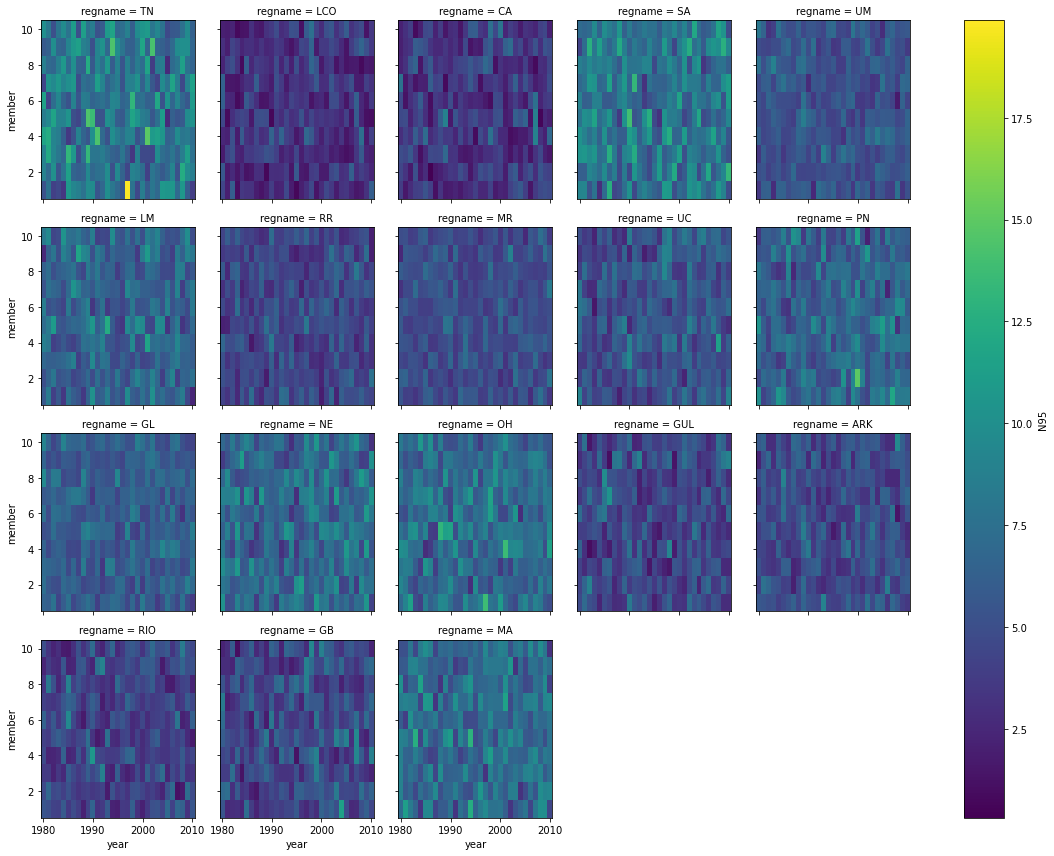

In [166]:
n95_reg.plot(col='regname', col_wrap=5);

In [7]:
# Create region name list based on numerical order
regorder = ['NE','MA', 'SA', 'GL', 'OH', 'TN', 'UM', 'LM', 'RR', 'MR', 'ARK', 'GUL', 'RIO', 'UC', 'LCO', 'GB', 'PN', 'CA']

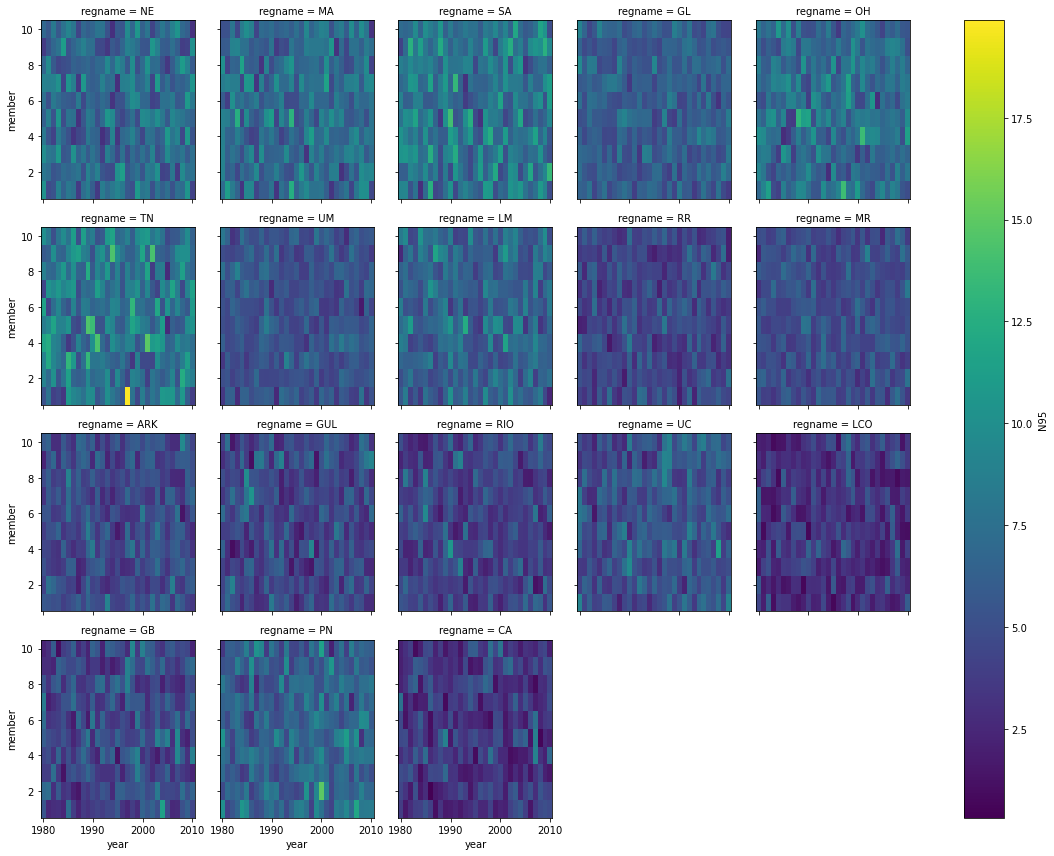

In [171]:
n95_reg.sel(regname=regorder).plot(col='regname', col_wrap=5);

Repeat for the Livneh high events

In [8]:
with xr.open_dataset(idir + 'Livneh_PRECT_1981-2010.nc') as dl:
    print('dl')

dl


In [172]:
with xr.open_dataset(idir + 'PRECT_Livneh_1981-2010_95th.nc') as file_nc:
    dp95_liv = file_nc.drop('quantile').squeeze()

Need to redefine the huc regions mask for Livneh as the data are on a slightly different grid.

In [9]:
# create geopandas regionmask
conus_mask_l = regionmask.mask_3D_geopandas(huc2_gdf,
                                          dl.lon,
                                          dl.lat)

# now add the region names to the mask
huc2_3d_mask_l = conus_mask_l.assign_coords({'regname' : ('region', huc2_gdf.str_id)})
huc2_3d_mask_l = huc2_3d_mask_l.swap_dims({'region':'regname'})

In [179]:
ptot_reg_l = dp95_liv.PTOT.where(huc2_3d_mask_l).groupby('regname').mean(['lon', 'lat'])
p95tot_reg_l = dp95_liv.P95Tot.where(huc2_3d_mask_l).groupby('regname').mean(['lon', 'lat'])
n95_reg_l = dp95_liv.N95.where(huc2_3d_mask_l).groupby('regname').mean(['lon', 'lat'])

ptot_reg_l.attrs['title'], ptot_reg_l.attrs['creator'], ptot_reg_l.attrs['description'] = 'Historical Annual Total Precipitation', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Annual Total Precip from Livneh 1981-2010'
p95tot_reg_l.attrs['title'], p95tot_reg_l.attrs['creator'], p95tot_reg_l.attrs['description'] = 'Historical P95Tot Precipitation', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Contribution of 95% events to Annual Total Precip from Livneh 1981-2010'
n95_reg_l.attrs['title'], n95_reg_l.attrs['creator'], n95_reg_l.attrs['description'] = 'Historical Number of P95 per year', 'Created Mari Tye September 2022', 'HUC2 Regional Averages Number of P95 events per year from Livneh 1981-2010'

# save for later
ptot_reg_l.to_netcdf('Data/PTOT_Livneh_HUC2_1981-2010.nc')
p95tot_reg_l.to_netcdf('Data/P95Tot_Livneh_HUC2_1981-2010.nc')
n95_reg_l.to_netcdf('Data/N95_Livneh_HUC2_1981-2010.nc')


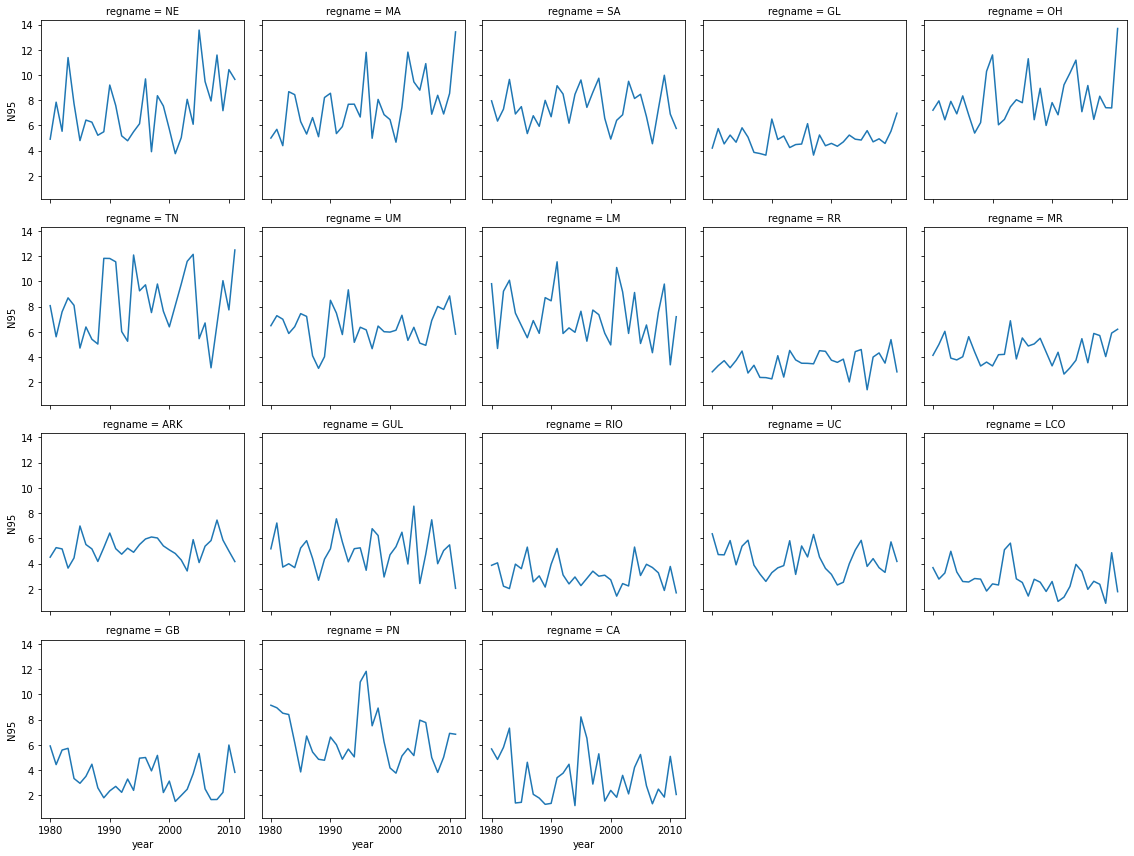

In [180]:
n95_reg_l.sel(regname=regorder).plot(col='regname', col_wrap=5);

Count the number of wet days per month.
Then take mean over the HUCS and save files for plotting.

In [14]:
nwd_cesm = xr.where(dp.PRECT>1,1,0).resample(date='1m').sum()
nwd_liv = xr.where(dl.prec>1,1,0).resample(time='1m').sum()
nwd_fut = xr.where(df.PRECT>1,1,0).resample(date='1m').sum()

In [32]:
nwd_fut

<xarray.DataArray 'PRECT' (member: 10, date: 372, lat: 29, lon: 47)>
array([[[[ 5,  8,  4, ..., 17, 15, 14],
         [ 3,  5,  2, ..., 14, 15, 15],
         [ 3,  2,  1, ..., 14, 16, 15],
         ...,
         [20, 20, 20, ..., 16, 16, 16],
         [20, 19, 19, ..., 15, 15, 16],
         [18, 16, 14, ..., 15, 14, 15]],

        [[ 4,  6,  3, ..., 14, 10, 11],
         [ 5,  5,  4, ..., 16, 16, 13],
         [ 6,  5,  5, ..., 17, 15, 12],
         ...,
         [19, 19, 17, ..., 11,  9, 10],
         [19, 17, 14, ..., 10, 10,  9],
         [15, 12,  7, ..., 10,  9, 10]],

        [[ 8,  7,  7, ..., 15, 16, 15],
         [ 9,  9,  8, ..., 15, 16, 15],
         [11, 10,  9, ..., 16, 15, 16],
         ...,
...
         ...,
         [13, 13, 13, ..., 14, 14, 12],
         [14, 15, 15, ..., 13, 15, 15],
         [17, 16, 16, ..., 16, 16, 13]],

        [[ 5,  5,  5, ..., 20, 19, 21],
         [ 5,  4,  6, ..., 19, 18, 21],
         [ 5,  5,  5, ..., 20, 20, 19],
         ...,
         [24, 22, 22, ..., 12, 12,  9],
         [24, 21, 18, ..., 10, 11, 11],
         [23, 17, 14, ...,  9, 11, 12]],

        [[ 4,  4,  4, ..., 15, 15, 16],
         [ 5,  4,  5, ..., 15, 14, 16],
         [ 4,  4,  5, ..., 14, 13, 15],
         ...,
         [24, 22, 22, ..., 10, 10, 10],
         [23, 22, 18, ..., 12, 12, 11],
         [22, 16, 15, ..., 14, 12, 13]]]])
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
  * lat      (lat) float64 25.92 26.86 27.8 28.74 ... 49.48 50.42 51.36 52.3
  * lon      (lon) float64 235.0 236.2 237.5 238.8 ... 288.8 290.0 291.2 292.5
  * date     (date) datetime64[ns] 2040-01-31 2040-02-29 ... 2070-12-31

In [33]:
nwd_reg_l = nwd_liv.where(huc2_3d_mask_l).groupby('regname').mean(['lon', 'lat'])
nwd_reg_c = nwd_cesm.where(huc2_3d_mask).groupby('regname').mean(['lon', 'lat'])
nwd_reg_f = nwd_fut.where(huc2_3d_mask).groupby('regname').mean(['lon', 'lat'])

nwd_reg_l.attrs['title'], nwd_reg_l.attrs['creator'], nwd_reg_l.attrs['description'] = 'Historical NWD per Month and year', 'Created Mari Tye April 2023', 'HUC2 Regional Averages Number of days >1mm from Livneh 1981-2010'
nwd_reg_c.attrs['title'], nwd_reg_c.attrs['creator'], nwd_reg_c.attrs['description'] = 'Historical NWD per month and year', 'Created Mari Tye April 2023', 'HUC2 Regional Averages Number of days >1mm from CESM 1981-2010'
nwd_reg_f.attrs['title'], nwd_reg_f.attrs['creator'], nwd_reg_f.attrs['description'] = 'Future NWD per month and year', 'Created Mari Tye April 2023', 'HUC2 Regional Averages Number of days >1mm from CESM 2040-2070'

# save for later
nwd_reg_l.to_netcdf('Data/NWD_bymon_Livneh_HUC2_1981-2010.nc')
nwd_reg_c.to_netcdf('Data/NWD_bymon_CESM2_HUC2_1981-2010.nc')
nwd_reg_f.to_netcdf('Data/NWD_bymon_CESM2_HUC2_2040-2070.nc')


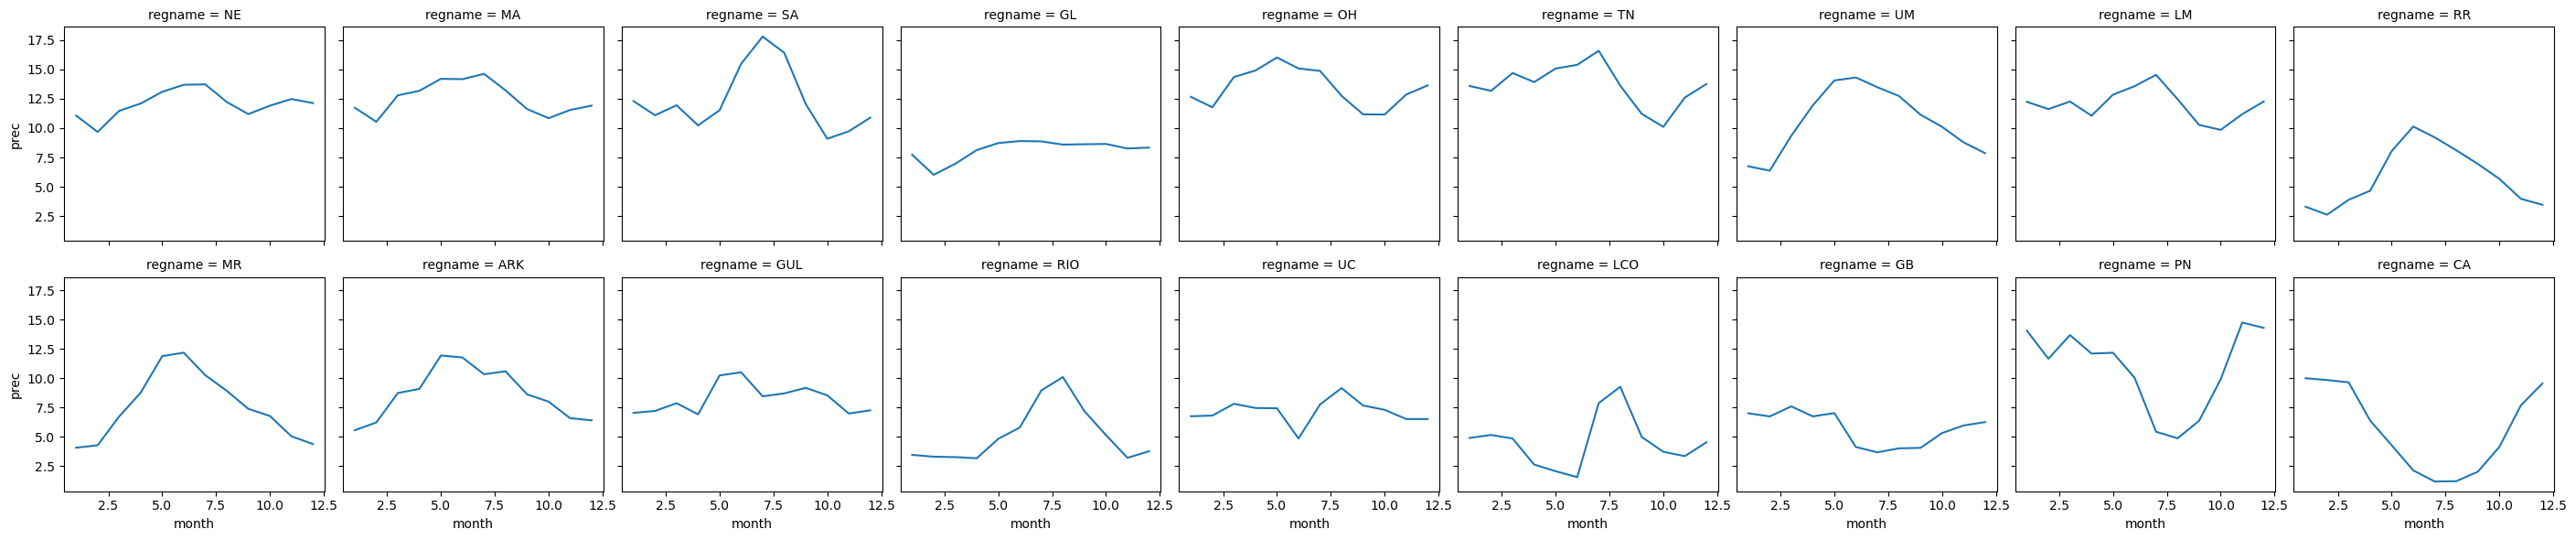

In [22]:
nwd_reg_l.groupby('time.month').mean('time').sel(regname=regorder).plot(col='regname', col_wrap=9);

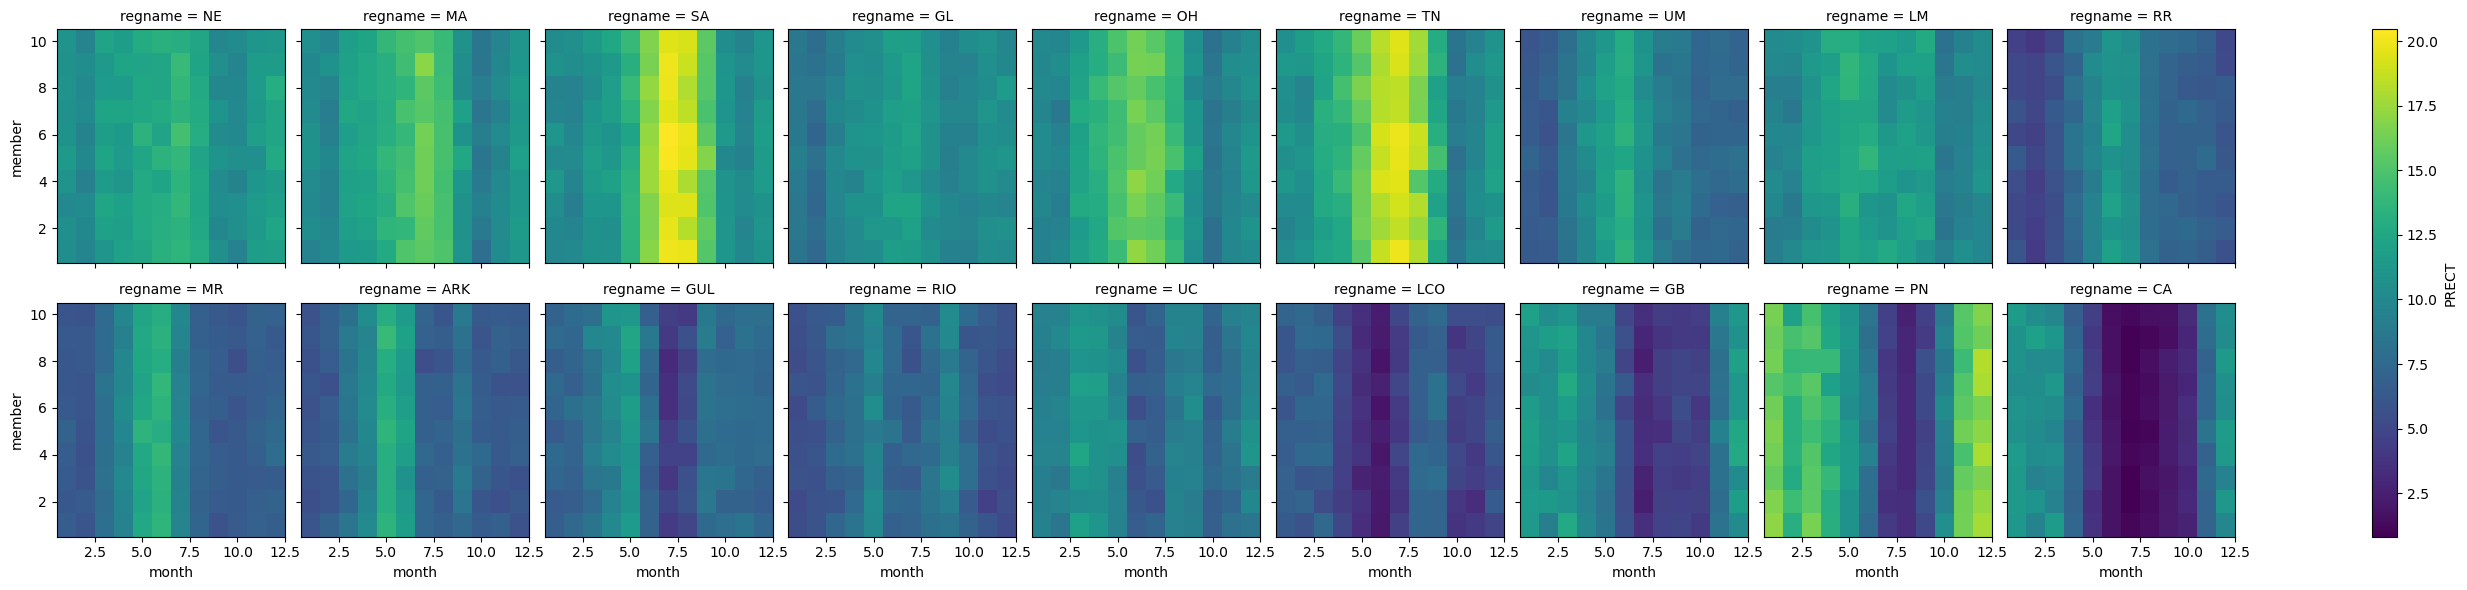

In [25]:
nwd_reg_c.groupby('date.month').mean('date').sel(regname=regorder).plot(col='regname', col_wrap=9);

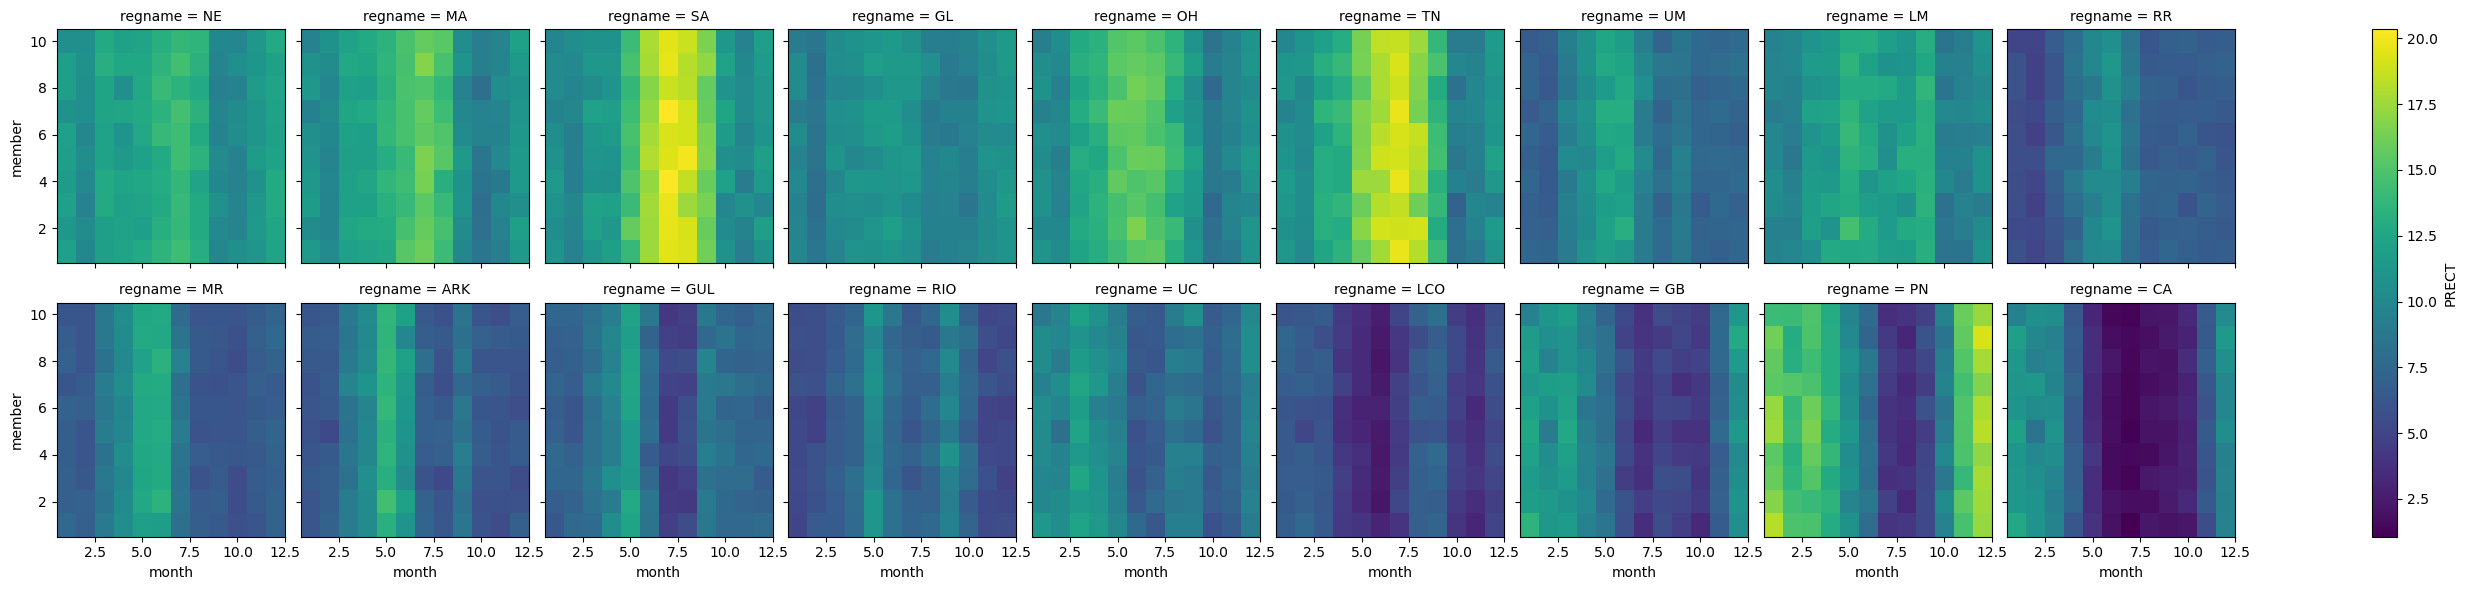

In [34]:
nwd_reg_f.groupby('date.month').mean('date').sel(regname=regorder).plot(col='regname', col_wrap=9);